In [37]:
#!pip install synapseclient

In [38]:
#!pip install synapseutils

In [39]:
#  import synapseclient 
#  import synapseutils 
 
#  syn = synapseclient.Synapse() 
#  syn.login('finamintoastcrunch','1Hjldria!') 
#  files = synapseutils.syncFromSynapse(syn, ' syn2825306 ') 

In [40]:
# !pip install -q tensorflow-model-optimization

# Import Libraries

In [41]:
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.layers import*
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K
# from keras.layers import Input
# from keras.layers import Dense
# from keras.layers import Conv1D
# from keras.layers import Conv1DTranspose
# from keras.layers import Flatten, Reshape

import os
from glob import glob
from tqdm import tqdm
from tensorflow.keras import losses
from sklearn.preprocessing import StandardScaler
import tensorflow_model_optimization as tfmot
from sklearn.preprocessing import MinMaxScaler


from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

import warnings

# from interpret import show
# from interpret.blackbox import ShapKernel
import shap

In [46]:
df = pd.DataFrame

In [47]:
tf.config.list_physical_devices(
    device_type=None
)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [48]:
isEager = tf.executing_eagerly()
isEager

True

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [51]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Load DS

In [52]:
NUM_PARENTS = None #we compute this from the gold standard
NUM_TARGETS = 100
NUM_TIME_STEPS = 21
NUM_REPLICATES = 10 
ds = str(1) #2,3,4,5

In [54]:
# dirty_RGM = r'Regulations_Control_Altona.csv'
dirty_regulations = r'insilico_size100_'+ ds + r'_timeseries.csv'

In [57]:

def fix_dataset(dirty_regulations = dirty_regulations):
    dirtyReg = pd.read_csv(dirty_regulations,  index_col = 0,)# on_bad_lines='skip')
    dirtyReg = dirtyReg.dropna(axis=0)
    dirtyReg = dirtyReg.select_dtypes(include=np.number)
    dirtyReg = dirtyReg.to_numpy() #reshape would not work in this case. 

    dRegs = np.zeros(shape=(NUM_REPLICATES, NUM_TIME_STEPS, NUM_TARGETS), dtype=np.float)
    for i in range(NUM_REPLICATES):
        dRegs[i] = dirtyReg[NUM_TIME_STEPS*i : NUM_TIME_STEPS*(i+1)]
    dRegs.shape

    ds = dRegs
    ret = np.zeros(shape=(NUM_REPLICATES,NUM_TIME_STEPS, NUM_TARGETS))

    # for i in range(0,NUM_REPLICATES*NUM_TIME_STEPS, 4):
    #     for j in range(0, NUM_REPLICATES):
    #         dataset[j][:,i//NUM_REPLICATES] = dirtyR[:,(i+j)]
    
    ds[ds==0.0] = np.nan #we do this so the scaling ignores 0.0 #CHECKED


    for i in range(NUM_REPLICATES):
        regScaled = StandardScaler().fit_transform(ds[i].flatten().reshape((-1,1)))
        regScaled = MinMaxScaler().fit_transform(ds[i].flatten().reshape((-1,1))) #ignores np.nan
        regScaled = regScaled.reshape((NUM_TARGETS, NUM_TIME_STEPS))
        regScaled = np.nan_to_num(regScaled, nan= 0.0)
        ret[i] = regScaled.T
    return ret

dataset = fix_dataset()
dataset.shape

(10, 21, 100)

In [58]:
beanIntensities = dataset[0:8]
validation = dataset[8:]
allData = dataset
print(beanIntensities.shape, validation.shape, allData.shape)

(8, 21, 100) (2, 21, 100) (10, 21, 100)


In [59]:
#the third replicate is trash. we will not use it. 
# df(dataset[3]).head(11) 

In [60]:
# regulator_gene_matrix = np.load("soyBeanRGM.npy")
# regulator_gene_matrix = regulator_gene_matrix.astype('float32')
# regulator_gene_matrix.shape

# Load Gold Standard

In [61]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_" + ds + r".csv", header=None)


In [63]:
def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )

gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_TARGETS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection



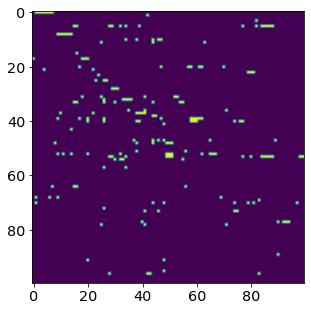

In [64]:
plt.imshow(goldIm)

In [65]:
non_zero = np.nonzero(goldIm) #non-zero hold all the true connections
#non_zero = np.array(np.unravel_index(non_zero, shape = (NUM_PARENTS, NUM_TARGETS)))

# RGM and RGM+

In [66]:
regulator_gene_matrix = goldIm.astype(np.float32) #I set rgm to gold because I didnt not want ot re-write everything
superParent = regulator_gene_matrix.copy()
ones = np.ones((NUM_TARGETS))
parentIndex = []
not_parentIndex = []
for i in range(len(regulator_gene_matrix)):
    if (np.isin(regulator_gene_matrix[i], [1])).any():
        #print(i)
        superParent[i] = ones 
        parentIndex.append(i)
    else:
        not_parentIndex.append(i)

parentIndex = np.array(parentIndex)
parentIndex = tf.convert_to_tensor(parentIndex)
parent_idx = parentIndex.numpy()
not_parentIndex = np.array(not_parentIndex)
not_parentIndex = tf.convert_to_tensor(not_parentIndex)
print("shape of parent index", parentIndex.shape)




#the code below runs the experiment without any known regulators
regulator_gene_matrix = np.ones((NUM_TARGETS,NUM_TARGETS), dtype='float32') #we keep this because we want to not mess with the weight init
# superParent = np.ones((NUM_TARGETS, NUM_TARGETS), dtype = 'float32')
# parentIndex = np.arange(stop=NUM_PARENTS)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()

shape of parent index (44,)


In [67]:
NUM_PARENTS = parentIndex.shape[0]
NUM_PARENTS

44

In [68]:
parentIndex

<tf.Tensor: shape=(44,), dtype=int32, numpy=
array([ 0,  1,  3,  5,  8, 10, 11, 15, 17, 20, 21, 22, 23, 25, 28, 31, 32,
       33, 36, 37, 38, 39, 40, 41, 43, 47, 48, 51, 52, 53, 54, 57, 64, 68,
       69, 70, 72, 73, 77, 78, 89, 91, 95, 96])>

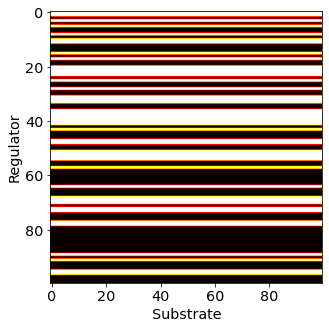

In [69]:
plt.imshow(superParent, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

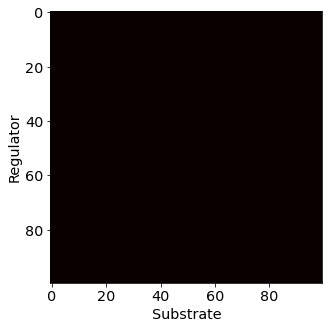

In [70]:
plt.imshow(regulator_gene_matrix, cmap='hot');
plt.xlabel("Substrate");
plt.ylabel("Regulator");

# Custom Loss

In [71]:
# superParent = regulator_gene_matrix.copy() #init the super parent with the ordinary RGM, and do forward passes with super parent
# #print(superParent.shape)

# ones = np.ones((NUM_TARGETS))
# parentIndex = []
# not_parentIndex = []
# for i in range(len(regulator_gene_matrix)):
#     if (np.isin(regulator_gene_matrix[i], [1])).any():
#         #print(i)
#         superParent[i] = ones 
#         parentIndex.append(i)
#     else:
#         not_parentIndex.append(i)

# parentIndex = np.array(parentIndex)
# parentIndex = tf.convert_to_tensor(parentIndex)
# parent_idx = parentIndex.numpy()
# not_parentIndex = np.array(not_parentIndex)
# not_parentIndex = tf.convert_to_tensor(not_parentIndex)
# print("shape of parent index", parentIndex.shape)

def ignore_noParent_MSE_old(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
    y_true_pruned = tf.gather(y_true,parentIndex, axis =2) 
    #print(y_true_pruned.shape
    y_pred_pruned = tf.gather(y_pred, parentIndex, axis =2)   
    return l(y_true_pruned, y_pred_pruned)

#this will not work if the entire dataset is -1 (degenerate), or has only one actual value (also degen)
def ignore_noParent_MSE(y_true, y_pred): 
    l = tf.keras.losses.MeanSquaredError()
   # print(y_true.shape) #(None, 44, 372)

    #get the parents and flatten them
    y_true_pruned = tf.gather(y_true, parentIndex, axis = 2) #axis 2 because batch, time, gene
    y_true_pruned = tf.reshape(y_true_pruned, shape=([tf.size(y_true_pruned)] ) )

   # print(y_true_pruned.shape)
   # print("tf size", tf.size(y_true_pruned))

    y_pred_pruned = tf.gather(y_pred, parentIndex, axis = 2) 
    y_pred_pruned = tf.reshape(y_pred_pruned, shape=([tf.size(y_pred_pruned)]) )

    #get the index of the parents which are not -1
    y_true_posID = tf.where(y_true_pruned >= 0) #gets args
    y_true_posID = tf.squeeze(y_true_posID)
    #get the idx of all the -1s 
    y_true_negID = tf.where(y_true_pruned < 0) 
    y_true_negID = tf.squeeze(y_true_negID)

    #get all the -1s in the parents 
    y_true_neg = tf.gather(y_true_pruned, y_true_negID) #get all the -1s in y_true
    y_pred_neg = tf.gather(y_pred_pruned, y_true_negID) #get the corresponding values for y_pred

    #get the indexes where pred should be -1 but is not. get the corresponding index for ytrue
    y_shouldBeNegButIsntID = tf.where(y_pred_neg >= 0)  
    y_shouldBeNegButIsntID = tf.squeeze(y_shouldBeNegButIsntID) #get the idx which should be -1 for prediction but are not
    y_true_wrong = tf.gather(y_true_pruned, y_shouldBeNegButIsntID) #get the same corresponding values from ytrue
    y_shouldBeNegButIsnt = tf.gather(y_pred_pruned, y_shouldBeNegButIsntID) #this has all the wrongly predicted values which should be -1 but are not

    y_true_pos = tf.gather(y_true_pruned, y_true_posID)
    y_pred_pos = tf.gather(y_pred_pruned, y_true_posID)

    if tf.size(y_shouldBeNegButIsnt) == 0: #we can not concatenate if the size is 0. 
        return l(y_true_pos, y_pred_pos)

    if tf.size(y_shouldBeNegButIsnt) == 1: #dim goes away if size = 1. 
        y_shouldBeNegButIsnt = tf.expand_dims(y_shouldBeNegButIsnt, axis = 0) #should all be flattened
        y_true_wrong = tf.expand_dims(y_true_wrong, axis=0)

    #print("y_pred", (y_pred_pos), "y_true", (y_shouldBeNegButIsnt))
    try:
        y_pred_total = tf.concat([y_pred_pos, y_shouldBeNegButIsnt], axis = 0) #concatenate for total mse
        y_true_total = tf.concat([y_true_pos, y_true_wrong], axis = 0)
    except Exception as e:
        print(y_pred_pos.shape, y_shouldBeNegButIsnt.shape, tf.size(y_shouldBeNegButIsnt))
        return l(y_true_pos, y_pred_pos)

    return l(y_true_total, y_pred_total)

In [72]:
parent_idx

array([ 0,  1,  3,  5,  8, 10, 11, 15, 17, 20, 21, 22, 23, 25, 28, 31, 32,
       33, 36, 37, 38, 39, 40, 41, 43, 47, 48, 51, 52, 53, 54, 57, 64, 68,
       69, 70, 72, 73, 77, 78, 89, 91, 95, 96])

# Ordinary Auto Encoder

In [73]:
# class EncoderLinear(tf.keras.layers.Layer):
#     def __init__(self, rgm, input_dim=32, units=32):
#         super(EncoderLinear, self).__init__()
#         self.rgm = rgm
        
#         def init_weights(shape, dtype="float32"):

#             w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.rgm, dtype=dtype)

#             return w_init
        

#         self.w = tf.Variable(
#             initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
#             trainable=True,
#         )

#     def call(self, inputs):
#         X = inputs
#         return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

In [74]:
# class DecoderLinear(tf.keras.layers.Layer):
#     def __init__(self, rgm, input_dim=32, units=32):
#         super(DecoderLinear, self).__init__()
#         self.rgm = rgm

#         def init_weights(shape, dtype="float32"):

#             w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

#             return w_init
    
        
#         self.w = tf.Variable(
#             initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
#             trainable=True,
#         )

#     def call(self, inputs):
#         X = inputs
#         #return tf.matmul(X, tf.multiply((self.rgm), self.w))
#         X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
#         #return tf.matmul(inputs, self.w)
#         # v = tf.zeros_like(X)
#         # u = tf.ones_like(X)
#         # u = tf.math.scalar_mul(-3.0, u)
        
#         return X#tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        

In [75]:
# def encoder(parent_child_biological_association, num_hidden_units=21):
#     '''
#     Encoder structure
#     '''
#     '''
#     The data is time-series. Therefore, CNN to learn the temporal relationship between 
#     the intensities for each gene.
#     '''
#     en_conv = Conv1D(490, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS Conv1D(32, 3, activation = "relu")(parent_child_biological_association)
#     en_dense = Flatten()(en_conv)
#     phenotype = Dense(num_hidden_units)(en_dense)
#     return phenotype

# def decoder(X, num_protein_gene, time_steps):
#     '''
#     Decoder structure
#     '''
#     de_dense = Dense(1024)(X)#Dense(128)(X)
#     de_dense = Reshape((1, 1024))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
#     de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
#     #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
#     # gene_reconstruction = self.decoder_biological_operation(de_deconv)
#     return de_deconv

# def model(rgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 32):
#     inp = Input(shape=(time_steps, num_kinase_regulators))
#     x = EncoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(inp)
#     enc = encoder(x, num_hidden_units)
#     dec = decoder(enc, num_protein_gene, time_steps)
#     out = DecoderLinear(rgm, NUM_TARGETS, NUM_TARGETS)(dec)

#     _model = tf.keras.Model(inputs=inp, outputs=out)

#     return _model

In [76]:
# ordinaryAE = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS)
# ordinaryAE.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [77]:
# o = ordinaryAE.fit(beanIntensities, beanIntensities, epochs=200, verbose = True, validation_data=(validation, validation))
#print(o.history['loss'][-1]) #the final loss 

# Super Parent AutoEncoder

In [105]:
class EncoderLinearSuperParent(tf.keras.layers.Layer, tfmot.sparsity.keras.PrunableLayer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(EncoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.OGrgm, dtype=dtype)

            return w_init
        

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def get_prunable_weights(self):
        # Prune bias also, though that usually harms model accuracy too much.
        return [self.w]

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

class DecoderLinearSuperParent(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DecoderLinearSuperParent, self).__init__()
        self.rgm = rgm
        self.OGrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.rgm, dtype=dtype))

            return w_init
    
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        #return tf.matmul(X, tf.multiply((self.rgm), self.w))
        X = tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) 
        #return tf.matmul(inputs, self.w)
        # v = tf.zeros_like(X)
        # u = tf.ones_like(X)
        # u = tf.math.scalar_mul(-3.0, u)
        
        return X    #tf.where(tf.math.less(X, v), u, X) #where X is less than 0, return -1 
        
        
def encoder(parent_child_biological_association, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    #rnn = LSTM(units = num_hidden_units)(parent_child_biological_association)
    en_conv = Conv1D(32, 3, activation = "relu")(parent_child_biological_association) # 6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    phenotype = Dense(num_hidden_units)(en_dense)
    return phenotype

def decoder(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(128)(X)
    de_dense = Reshape((1, 128))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "relu")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelSuperParent(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21, sparsity = 0.0): #rgm is set to superparent, oldrgm is original rgm unmodified
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = tfmot.sparsity.keras.prune_low_magnitude(EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS),
                                                 pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(sparsity, 0))(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [106]:
def modelSuperParentSequential(rgm, oldRGM, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21): #rgm is set to superparent, oldrgm is original rgm unmodified
    m = tf.keras.Sequential()
    inp = Input(shape=(time_steps, num_kinase_regulators))
    x = EncoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(inp)
    enc = encoder(x, num_hidden_units)
    dec = decoder(enc, num_protein_gene, time_steps)
    out = DecoderLinearSuperParent(rgm, oldRGM, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [107]:
looseParent = modelSuperParent(superParent, superParent, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32, sparsity=0.98)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  
                    validation_data=(validation, validation), callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(o.history['loss'][-1]) #the final loss 

UnboundLocalError: local variable 'inp' referenced before assignment

In [81]:
looseParent.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21, 100)]         0         
                                                                 
 prune_low_magnitude_encoder  (None, 21, 100)          20002     
 _linear_super_parent (Prune                                     
 LowMagnitude)                                                   
                                                                 
 conv1d (Conv1D)             (None, 19, 32)            9632      
                                                                 
 flatten (Flatten)           (None, 608)               0         
                                                                 
 dense (Dense)               (None, 32)                19488     
                                                                 
 dense_1 (Dense)             (None, 128)               4224  

In [82]:
m = looseParent.get_layer(index=1).get_weights()

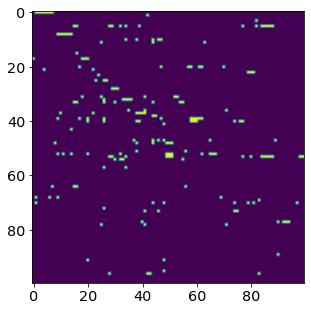

In [83]:
plt.imshow(goldIm)

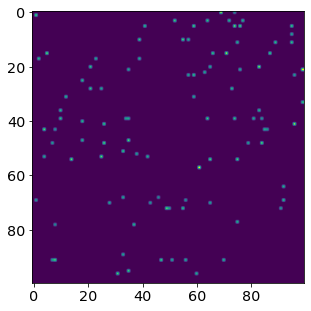

In [84]:
plt.imshow(np.abs(m[0]))

In [85]:
m[0].shape

(100, 100)

# DenseNetAutoEncoder

In [108]:
'''
a second copy of the layers which will be modified to be a denseNET auto encoder
'''

class DAE_Encoder_MASK(tf.keras.layers.Layer, tfmot.sparsity.keras.PrunableLayer): 
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Encoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm
        
        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.convert_to_tensor(self.oldrgm, dtype=dtype)

            return w_init
        
        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )
    
    def get_prunable_weights(self):
        # Prune bias also, though that usually harms model accuracy too much.
        return [self.w]

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(self.rgm, self.w))
    #tf.matmul(inputs, self.w)

    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })

class DAE_Decoder_MASK(tf.keras.layers.Layer):
    def __init__(self, rgm, oldrgm, input_dim=32, units=32):
        super(DAE_Decoder_MASK, self).__init__()
        self.rgm = rgm
        self.oldrgm = oldrgm

        def init_weights(shape, dtype="float32"):

            w_init = tf.random_normal_initializer()(shape=shape, dtype=dtype) * tf.transpose(tf.convert_to_tensor(self.oldrgm, dtype=dtype))

            return w_init

        self.w = tf.Variable(
            initial_value=init_weights(shape=(input_dim, units), dtype="float32"),
            trainable=True,
        )

    def call(self, inputs):
        X = inputs
        return tf.matmul(X, tf.multiply(tf.transpose(self.rgm), self.w)) #used to have a transpose


    def get_config(self):
        config = super().get_config()
        config.update({
            "rgm": self.rgm,
            "oldrgm": self.oldrgm,
            'input_dim': 32,
            'units' : 32
        })
        

def denseencoder2(parent_child_biological_association, inp, num_hidden_units=21):
    '''
    Encoder structure
    '''
    '''
    The data is time-series. Therefore, CNN to learn the temporal relationship between 
    the intensities for each gene.
    '''
    en_conv = Conv1D(NUM_TARGETS, 7, activation = "tanh")(parent_child_biological_association) # Conv1D(NUM_TARGETS, NUM_TIME_STEPS, activation = "tanh")(parent_child_biological_association)6*NUM_TARGETS
    en_dense = Flatten()(en_conv)
    inp = Flatten()(inp)
    d = Concatenate()([en_dense, inp]) #dense layer
    phenotype = Dense(num_hidden_units, activation="tanh")(d)
    return phenotype

def densedecoder2(X, num_protein_gene, time_steps):
    '''
    Decoder structure
    '''
    de_dense = Dense(NUM_TARGETS, activation = 'tanh')(X)
    de_dense = Reshape((1, NUM_TARGETS))(de_dense) #tf.reshape(de_dense, (self.batch_size,1,128))
    de_deconv = Conv1DTranspose(num_protein_gene, time_steps, activation = "tanh")(de_dense) #used to be transpose
    #de_deconv = Conv1D(num_protein_gene, time_steps, activation = "relu")(de_dense) 
    # gene_reconstruction = self.decoder_biological_operation(de_deconv)
    return de_deconv

def modelDense2(rgm, oldrgm, num_protein_gene, time_steps, num_kinase_regulators, num_hidden_units = 21, sparsity = 0.0):
    inp = Input(shape=(time_steps, num_kinase_regulators))
    
    x = tfmot.sparsity.keras.prune_low_magnitude(DAE_Encoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS),
                                                 pruning_schedule = tfmot.sparsity.keras.ConstantSparsity(sparsity, 0))(inp)
    #x = EncoderLinear2(x)
    enc = denseencoder2(x, inp, num_hidden_units)
    dec = densedecoder2(enc, num_protein_gene, time_steps)
    out = DAE_Decoder_MASK(rgm, oldrgm, NUM_TARGETS, NUM_TARGETS)(dec)

    _model = tf.keras.Model(inputs=inp, outputs=out)

    return _model

In [110]:
#dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS)
# dense = modelDense2(goldIm.astype(np.float32), goldIm.astype(np.float32), NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS)
dense = modelDense2(superParent, superParent, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=NUM_PARENTS)
dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
dense.fit(beanIntensities, beanIntensities, epochs=150,  verbose=True, validation_data=(validation, validation),
          callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])

Epoch 1/150
1/1 [==============================] - 2s 2s/step - loss: 0.2063 - val_loss: 0.1899
Epoch 2/150
1/1 [==============================] - 0s 33ms/step - loss: 0.2025 - val_loss: 0.1689
Epoch 3/150
1/1 [==============================] - 0s 35ms/step - loss: 0.1799 - val_loss: 0.1470
Epoch 4/150
1/1 [==============================] - 0s 36ms/step - loss: 0.1566 - val_loss: 0.1267
Epoch 5/150
1/1 [==============================] - 0s 34ms/step - loss: 0.1344 - val_loss: 0.1060
Epoch 6/150
1/1 [==============================] - 0s 33ms/step - loss: 0.1113 - val_loss: 0.0864
Epoch 7/150
1/1 [==============================] - 0s 35ms/step - loss: 0.0891 - val_loss: 0.0702
Epoch 8/150
1/1 [==============================] - 0s 33ms/step - loss: 0.0701 - val_loss: 0.0589
Epoch 9/150
1/1 [==============================] - 0s 30ms/step - loss: 0.0560 - val_loss: 0.0532
Epoch 10/150
1/1 [==============================] - 0s 36ms/step - loss: 0.0476 - val_loss: 0.0517
Epoch 11/150
1/1 [===

In [ ]:
dense.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 21, 100)]    0           []                               
                                                                                                  
 dae__encoder_mask (DAE_Encoder  (None, 21, 100)     10000       ['input_2[0][0]']                
 _MASK)                                                                                           
                                                                                                  
 conv1d_1 (Conv1D)              (None, 15, 100)      70100       ['dae__encoder_mask[0][0]']      
                                                                                                  
 flatten_1 (Flatten)            (None, 1500)         0           ['conv1d_1[0][0]']         

In [89]:
mask = dense.get_layer(index = 1)

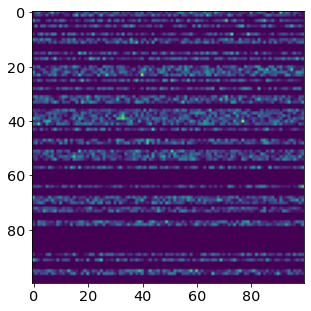

In [90]:
plt.imshow(np.abs(mask.get_weights()[0]))

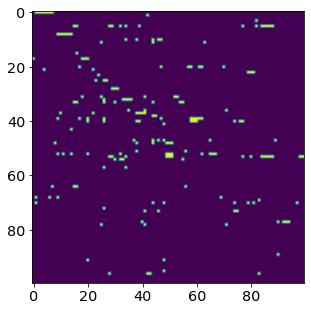

In [91]:
plt.imshow(goldIm)

# Reconstruction

In [92]:
o = dense.predict(validation)
o.shape

1/1 [==============================] - 0s 104ms/step


(2, 21, 100)

In [93]:
r = pd.DataFrame(o[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))
v = pd.DataFrame(validation[0].reshape(NUM_TIME_STEPS,NUM_TARGETS))

In [94]:
parent_idx

array([ 0,  1,  3,  5,  8, 10, 11, 15, 17, 20, 21, 22, 23, 25, 28, 31, 32,
       33, 36, 37, 38, 39, 40, 41, 43, 47, 48, 51, 52, 53, 54, 57, 64, 68,
       69, 70, 72, 73, 77, 78, 89, 91, 95, 96])

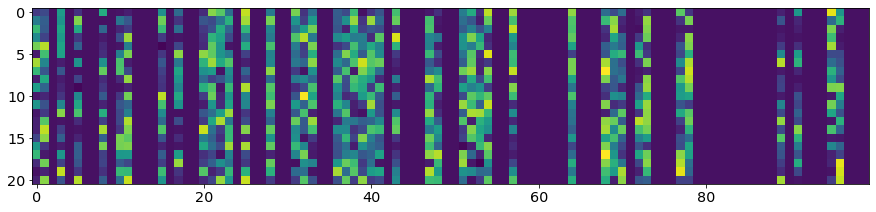

In [95]:
plt.imshow(o[0])

In [96]:
r[parent_idx].head(NUM_TIME_STEPS)

,0,1,3,5,8,10,11,15,17,20,...,69,70,72,73,77,78,89,91,95,96
0,0.106301,0.153197,0.438527,0.086138,0.495842,0.004548,0.031345,0.397616,0.262176,0.066762,...,0.154774,0.269714,0.033851,0.090694,0.608679,0.098833,0.039306,0.421596,0.798155,0.418635
1,0.324237,0.218598,0.407922,0.665617,0.000414,0.299781,0.197464,0.637985,0.092034,0.188123,...,0.675754,0.055036,0.017054,0.689302,0.091634,0.650503,0.187063,0.054472,0.265095,0.519023
2,0.545691,0.204699,0.463860,0.490206,0.248739,0.054110,0.112510,0.549887,0.272750,0.106001,...,0.712046,0.028131,-0.003911,0.665747,0.016084,0.020675,0.007568,0.031530,0.655631,0.036173
3,0.380017,0.136230,0.434827,0.101454,0.023312,0.169830,0.701221,0.103607,0.007574,0.081603,...,0.472581,0.243017,0.106347,0.634304,0.049879,0.680272,0.026364,0.006343,0.555752,0.006290
4,0.646442,0.735042,0.465067,0.230062,0.058986,0.009903,0.327829,-0.027733,0.144873,0.066432,...,0.313987,0.226307,0.423050,0.077070,0.186201,0.660955,0.115016,0.077359,0.708412,0.027674
5,0.024353,0.565936,0.457754,0.000835,0.072894,0.338199,0.655023,0.095840,0.680682,0.683856,...,0.499052,0.546820,0.557527,0.104970,0.145471,0.513996,0.373762,0.442693,0.156324,0.150466
6,0.712462,0.360147,0.029220,0.406882,0.398095,0.580884,0.029130,0.197747,0.312009,0.525640,...,0.280332,0.170417,0.082669,0.654767,0.378959,0.726244,0.734619,0.524153,0.268094,0.174564
7,0.544704,0.197069,0.192264,0.001080,0.622249,0.585917,0.149654,0.127057,0.466628,0.405276,...,0.282048,0.237454,0.011536,0.042436,0.145655,0.769188,0.018973,0.053022,0.520630,0.228498
8,0.032379,0.489273,0.025886,0.137195,0.063182,0.061796,0.689543,0.096492,0.417682,0.266571,...,0.205686,0.302298,0.023955,0.676401,0.592100,0.733841,0.124323,0.001651,0.413063,0.158162
9,0.445569,0.240564,0.048532,-0.025881,0.099617,0.002345,0.043624,0.088167,0.354678,0.513673,...,0.195204,0.055125,0.185960,0.693357,0.428937,0.646239,0.135563,0.034051,0.658853,0.667050


In [97]:
v[parent_idx].head(NUM_TIME_STEPS)

,0,1,3,5,8,10,11,15,17,20,...,69,70,72,73,77,78,89,91,95,96
0,0.165539,0.180589,0.560011,0.079586,0.508716,0.019554,0.027199,0.082960,0.224689,0.026477,...,0.169828,0.254118,0.061095,0.114898,0.557888,0.069743,0.067647,0.418742,0.649797,0.372000
1,0.312090,0.141910,0.471823,0.893201,0.038851,0.425922,0.273433,0.398319,0.214893,0.216249,...,0.620273,0.030791,0.045228,0.609454,0.064538,0.813326,0.183897,0.032882,0.301571,0.585549
2,0.590390,0.115723,0.387907,0.432077,0.041046,0.053468,0.135569,0.489693,0.274090,0.033111,...,0.689954,0.056324,0.004058,0.849022,0.002543,0.049414,0.042005,0.049530,0.787071,0.075389
3,0.410304,0.132296,0.455815,0.303180,0.006238,0.013363,0.761615,0.072770,0.015249,0.079311,...,0.413920,0.062084,0.184941,0.793252,0.048464,0.676961,0.045832,0.009768,0.632848,0.000535
4,0.824310,0.772086,0.405190,0.377347,0.065725,0.001102,0.669013,0.022438,0.052371,0.038634,...,0.252905,0.176472,0.387883,0.195963,0.131835,0.840921,0.098045,0.098564,0.748598,0.157358
5,0.034440,0.596945,0.530159,0.005760,0.050265,0.111564,0.701873,0.053790,0.746340,0.671955,...,0.585836,0.684460,0.517849,0.087319,0.194498,0.484446,0.481704,0.390982,0.167465,0.157259
6,0.627490,0.390529,0.017829,0.388743,0.408687,0.469491,0.099888,0.213590,0.283055,0.704743,...,0.359900,0.028204,0.119546,0.807657,0.150415,0.683750,0.842857,0.598306,0.292341,0.102462
7,0.496774,0.256222,0.191654,0.048578,0.444043,0.684467,0.051948,0.038153,0.755667,0.504756,...,0.326704,0.228026,0.021498,0.038564,0.180456,0.856892,0.025505,0.088971,0.683340,0.134511
8,0.015199,0.659832,0.049455,0.011542,0.184373,0.071314,0.724374,0.076524,0.096145,0.201401,...,0.294777,0.382825,0.008896,0.689842,0.811688,0.786941,0.105239,0.000469,0.395696,0.161586
9,0.684259,0.244350,0.081378,0.009457,0.049413,0.001550,0.450520,0.083016,0.434325,0.588546,...,0.256642,0.049224,0.171368,0.736846,0.516359,0.704210,0.208304,0.045683,0.690326,0.695327


In [98]:
ignore_noParent_MSE(validation, o)

<tf.Tensor: shape=(), dtype=float32, numpy=0.024579536>

# Test OG SHAP

ms shap sux

In [99]:
tf.executing_eagerly()

True

In [100]:
inp = Input(shape=(NUM_TIME_STEPS,NUM_TARGETS))
re = tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS, NUM_TARGETS))(inp)
dout = dense(re)
doutRe = tf.squeeze(tf.keras.layers.Reshape(target_shape=(NUM_TIME_STEPS*NUM_TARGETS,1))(dout), axis=-1)
denseRE = tf.keras.Model(inputs=inp, outputs=doutRe)

In [101]:
denseRE.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 21, 100)]         0         
                                                                 
 reshape_2 (Reshape)         (None, 21, 100)           0         
                                                                 
 model_1 (Functional)        (None, 21, 100)           463144    
                                                                 
 reshape_3 (Reshape)         (None, 2100, 1)           0         
                                                                 
 tf.compat.v1.squeeze (TFOpL  (None, 2100)             0         
 ambda)                                                          
                                                                 
Total params: 463,144
Trainable params: 463,144
Non-trainable params: 0
_____________________________________________________

In [102]:
denseRE(validation)

<tf.Tensor: shape=(2, 2100), dtype=float32, numpy=
array([[0.10630108, 0.15319712, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15712224, 0.21561475, 0.        , ..., 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [ ]:

model = denseRE
# def map2layer(x, layer):1
#     feed_dict = dict(zip([model.layers[0].input.ref()], [x.copy()]))
#     return K.get_session().run(model.layers[layer].input, feed_dict)


e = shap.GradientExplainer(model,
    #(model.layers[0].input, model.layers[-1].output),
    allData,
    local_smoothing=0 # std dev of smoothing noise
)
sv = e.shap_values(allData)
# shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

Number of features: 100


100%|██████████| 2100/2100 [20:24<00:00,  1.72it/s] 


In [86]:
sv= np.array(sv)

In [124]:
sv.shape

(2100, 10, 21, 100)

In [125]:
uv = np.copy(sv)

In [143]:
uv = np.reshape(uv, newshape=(21, 100, 10, 21, 100)) #should this be 100, 21... or 21, 100...?

In [144]:
# 21 time steps, 10 replicates, 100 protiens

In [145]:
uv.shape

(21, 100, 10, 21, 100)

In [146]:
av1 = np.average(uv, axis = 2)
av2 = np.sum(uv, axis = 2)

In [147]:
av1.shape, av2.shape

((21, 100, 21, 100), (21, 100, 21, 100))

In [148]:
av1 = np.average(av1, axis = 2)

av2 = np.sum(av2, axis= 2)
av1.shape, av2.shape

((21, 100, 100), (21, 100, 100))

In [149]:
av1 = np.average(av1, axis = 0) #change this to fix axis order

av2 = np.sum(av2, axis = 0) 
av1.shape, av2.shape


((100, 100), (100, 100))

In [174]:
parent_idx

array([ 0,  4,  9, 14, 22, 24, 25, 35, 36, 37, 39, 41, 42, 43, 44, 45, 53,
       54, 56, 61, 62, 63, 64, 65, 66, 68, 71, 72, 74, 81, 82, 84, 86, 89,
       90, 91, 92, 95, 97, 98, 99])

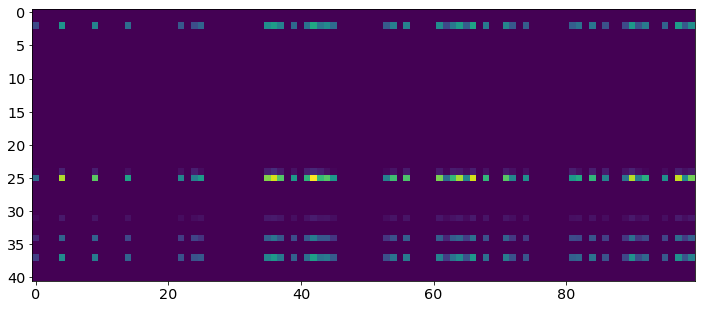

In [180]:
plt.imshow(np.clip(av2, a_min=0.0, a_max=None))

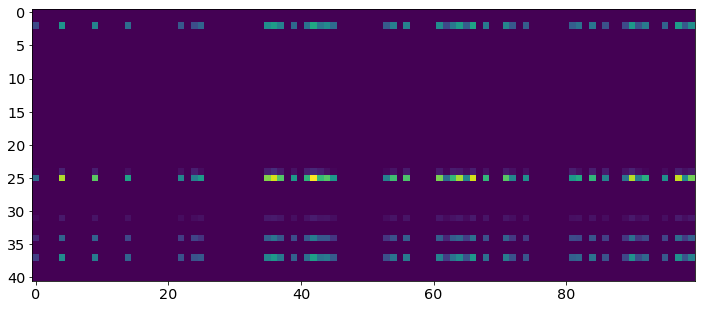

In [182]:
plt.imshow(np.clip(av1, a_min=0.0, a_max=None))

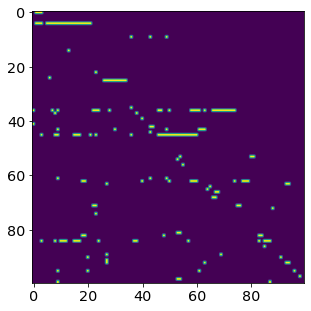

In [84]:
plt.imshow(goldIm)

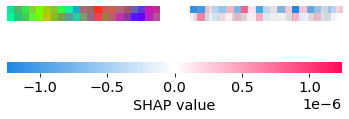

In [72]:
av1.min(), av1.max()

(-5.361398619628737e-05, 1.6010203871349165e-05)

In [78]:
sv.argmax()
np.unravel_index(8506244, sv.shape)

(2025, 0, 12, 44)

In [64]:
validation.shape

(2, 21, 100)

In [65]:
valR = validation.reshape(( validation.shape[0], validation.shape[1]*validation.shape[2]))
valR.shape

(2, 2100)

In [80]:
valR.mean(axis=1).shape

(2,)

array([[0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.]])

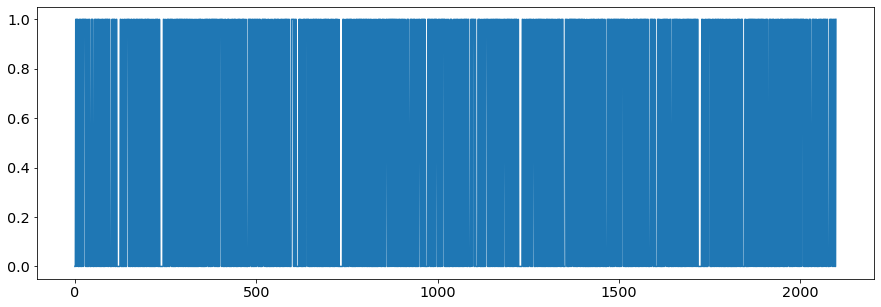

In [85]:
bs = np.nonzero(valR >valR.mean())
tmagIm = np.zeros(shape=valR.shape) 
tmagIm[bs] = 1
plt.plot(tmagIm[0]);
bs = tmagIm
del tmagIm


In [86]:
# import numpy as np
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split

# from sklearn.ensemble import RandomForestClassifier
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline

# import warnings

# from interpret import show
# from interpret.blackbox import ShapKernel

seed = 42
np.random.seed(seed)
# X, y = load_breast_cancer(return_X_y=True, as_frame=True)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed)

# pca = PCA()
# rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=seed)

# blackbox_model = Pipeline([('pca', pca), ('rf', rf)])
# blackbox_model.fit(X_train, y_train)

blackbox_model = denseRE

shap = ShapKernel(blackbox_model.predict, bs)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    shap_local = shap.explain_local(bs, bs)

show(shap_local, 0)

1/1 [==============================] - 0s 16ms/step


Exception: multiclass SHAP not supported

# Latent Space Size Experiment

In [ ]:
# print(NUM_PARENTS, NUM_TARGETS)

In [ ]:
# #to test on entire DS: 
# N = 50
# hidden = np.arange(1,NUM_PARENTS+1, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(allData, allData, epochs=40,  verbose=0)
#         test_hat = dense(allData) #, verbose = 0)
#         loss = ignore_noParent_MSE(allData, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 


#To test on Test set:
# N = 40
# hidden = np.arange(2,24, 1) #range(1,32)
# lossMatrix = []
# for i in tqdm(range(N)):
    
#     losses = []
#     for value in (hidden):
#         dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, value)
#         dense.compile(optimizer='adam', loss=ignore_noParent_MSE)
#         dense.fit(beanIntensities, beanIntensities, epochs=40,  verbose=0)
#         test_hat = dense(validation) #, verbose = 0)
#         loss = ignore_noParent_MSE(validation, test_hat)
#         losses.append(loss)
#         tf.keras.backend.clear_session()
#     lossMatrix.append(losses)
    
# lossMatrix = np.array(lossMatrix)
# #run 100 times 

In [ ]:
# avgMSE = np.average(lossMatrix, axis = 0)
# plt.plot(hidden, avgMSE);
# plt.xlabel("Latent Space Size",fontsize=15);
# plt.ylabel("MSE",fontsize=15);
# plt.title("Glycine Max: MSE with Respect to the Latent Space Size", fontweight='bold', fontsize = 18);

In [ ]:
# lm = pd.DataFrame(lossMatrix)
# lm.to_csv("lossmatrix4lisa_dream4.csv")

In [ ]:
# temp = pd.read_csv("lossmatrix4lisa_dream4.csv").to_numpy()
# print(temp.shape)
# avgMSE = np.average(lossMatrix, axis=0)

In [ ]:
# plt.plot(hidden, avgMSE)

# Lazy Kernels

In [ ]:
dense = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, NUM_PARENTS)
dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

In [ ]:
d = np.array(dense.get_weights())

In [ ]:
d[0].shape

In [ ]:


def do_lazy_train(epochs, hidden = NUM_PARENTS):

    '''trains the auto encoder epoch by epoch and returns the weights of the first layer'''
    ep = epochs
    #hidden = [hidden,] #range(1,32)
    lossMatrix = []
    lazy_weights = []

    dense = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, hidden)
    dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)
    
    # dense = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, num_hidden_units=hidden)
    # dense.compile(optimizer=tf.keras.optimizers.Adam(), loss=ignore_noParent_MSE)

    #for i in tqdm(range(ep)):
    for i in range(ep):
        dense.fit(allData, allData, validation_data=(validation, validation), epochs=1,  verbose=0, callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
        lazy_weights.append(dw := dense.get_weights()[0])
        test = dense(validation) #, verbose = 0)
        loss = ignore_noParent_MSE(validation, test)
        lossMatrix.append(loss)
        
    lossMatrix = np.array(lossMatrix) #loss matrix no longer returns anything 
    lazy_weights = np.array(lazy_weights)
    # print("lazy weights", lazy_weights.shape)

    return lossMatrix, lazy_weights #loss matrix no longer returns anything 

In [ ]:
#https://proceedings.mlr.press/v162/rachwan22a/rachwan22a.pdf Winning the Lottery Ticket Ahead of Time:
def lazyKernelRegime(w, parent_idx=parent_idx):
    '''compute when each weight enters lazy kernel regime'''
    
    # print("wshape", w.shape)

    firstLayer = [] 
    for i in range(len(w)):
         firstLayer.append(w[i]) #firstLayer.append(w[i][parent_idx])

    fL = np.array(firstLayer)    
    # print("print fL", fL.shape, fL.dtype, fL[0], fL[1],)
    d0 = np.square(fL[1] - fL[0])
    # print("do", d0.shape, d0)
    
    kernelChange = []
    for i in range(1,len(fL)):
        dt = np.square(fL[i] - fL[0])
        dt_minus1 = np.square(fL[i-1] - fL[0])   
        d = np.abs(dt - dt_minus1)/d0                        #eq 11 from the paper
        kernelChange.append(d)
    
    kernelChange = np.moveaxis(kernelChange, 0, 2)
    # plt.plot(kernelChange[0][0]);
    # plt.title("$|\Delta W|$ vs Epoch")
    # plt.xlabel("Epoch")
    # plt.ylabel("$|\Delta W|$")

    return np.array(kernelChange)

In [ ]:
#TODO: try setting top parents to num epochs trained rather than culling process
def compute_distrib(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    z = np.zeros(shape=(NUM_TARGETS, NUM_TARGETS))


    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                z[parent][child] = (np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))

    return z 
    
    stop = np.array(stop)
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [ ]:
def compute_distrib_old(change, t, raw = False): #raw means return the unshaped indicies. 
    stop = []

    for parent in range(len(change)):
        for child in range(len(change[0])):
            try:
                stop.append(np.min(np.argwhere(change[parent][child] < t)))
            except ValueError:
                stop.append(len(change))
                # print(parent, child)
                # plt.plot(change[parent][child])
                # assert(False)

    
    stop = np.array(stop).flatten()
    # print("stop shape", stop.shape)
    # print(stop.shape)
    var = np.std(stop)
    # print(var)
    # assert(False)
    mean = np.average(stop)
   # print("mean, variance", mean, var)
    top_parents = np.argwhere(stop > (mean + 0.5*var)) #get the parents which take more than 2 stds to stop training
    # print("top parents ", top_parents)
    # assert(False)
    top_parent_child = []
    for tp in top_parents:
        top_parent_child.append(np.unravel_index(tp, shape = (NUM_PARENTS, NUM_TARGETS)))

    if raw == False:
        plt.hist(stop)
        plt.xlabel("Epoch where regulator-target-weight began changing by at most "+ str(t));
        plt.ylabel("Number of parent-child-weights");
        plt.title("Histogram of weight stops");
        print("average stop: ", mean);

    if raw == True:
        return np.array(top_parents)

    return np.array(top_parent_child)

In [ ]:
def lazyKernels(N):

    candidates = []
    final_w = []
    for i in tqdm(range(N)):
        lm, lazy_weights = do_lazy_train(epochs=100)
        # print("lm", lm)
        change = lazyKernelRegime(lazy_weights)
        # print("change",change.shape)
        # assert(False)
        top_pr = np.squeeze(compute_distrib(change, t = 0.2, raw=True))
        candidates.append(top_pr)
        final_w.append(lazy_weights[-1]) #final w is used for magntiude calculations at the end
        tf.keras.backend.clear_session()
    
    final_w = np.array(final_w)
    firstLayer = []
    for i in range(len(final_w)):
        firstLayer.append(np.abs(final_w[i])) #firstLayer.append(np.abs(final_w[i][parent_idx]))
    fw = np.array(firstLayer)
    candidates = np.array(candidates)

    fw_avg = np.average(fw, axis = 0)
    stop_avg = np.average(candidates, axis=0) 

    return stop_avg, fw_avg
    #print(fw_avg.shape)
    
    candidates = np.hstack(candidates)
    candidates = candidates.reshape(candidates.size)
    #print(candidates.shape)

    # plt.hist(candidates, bins=np.arange(0, NUM_PARENTS*NUM_TARGETS))
    # plt.title("Parent-Child Regulator Histogram")
    # plt.xlabel("Parent-Child Weight")
    # plt.ylabel("Num-Times parent-child relationship trained for top 5% of time")
    return candidates, fw_avg




In [113]:
#TODO: test reshaping in other orientation

In [ ]:
can, mag = lazyKernels(N = 5)

In [ ]:
gold = pd.read_csv("DREAM4_GoldStandard_InSilico_Size100_1.csv", header=None)

def keep_numeric(df):

    return df.applymap(lambda x: ''.join(filter(str.isdigit, str(x))) if isinstance(x, (int,float)) else ''.join(filter(str.isdigit, x)) )
gold = keep_numeric(gold)
goldnp = np.array(gold, dtype = 'int')
#subtract 1 from each index to match python index
goldnp[:,0] = goldnp[:,0] - 1
goldnp[:,1] = goldnp[:,1] - 1

goldIm = np.zeros(shape=(NUM_TARGETS,NUM_TARGETS))

for g in goldnp:
    reg = g[0]
    tar = g[1]
    connection = g[2]
    goldIm[reg][tar] = connection



In [ ]:
plt.imshow(can)

In [ ]:
plt.imshow(mag)

In [ ]:
score = np.multiply(can, mag)

In [ ]:
plt.imshow(score)

In [ ]:
plt.imshow(goldIm)
plt.title('True RT Combos');
print(sum(sum(goldIm)))

In [ ]:
tscore = np.nonzero(score > score.mean() + 0.8*score.std())
tscoreIm = np.zeros(shape=goldIm.shape) 
tscoreIm[tscore] = 1
plt.imshow(tscoreIm);
plt.title('Score Out');
print(sum(sum(tscoreIm)))

In [ ]:
plt.imshow(np.abs(goldIm-tscoreIm));
plt.title("Difference between Gold and our score")

In [ ]:
sum(sum(np.abs(goldIm-tscoreIm)))

In [ ]:
type(mag)

In [ ]:
tmag = np.nonzero(mag > mag.mean() + 3.0*mag.std())
tmagIm = np.zeros(shape=goldIm.shape) 
tmagIm[tmag] = 1
plt.imshow(tmagIm);
plt.title('Magnitude Out');

In [ ]:
#TODO: do box plot of scores and compare with score of goldIM
#TODO: Try shapley tf1 version
plt.boxplot(score[np.nonzero(goldIm)])

# load this with the gold IM mask after copying the weights of an old auto encoder. 


In [ ]:
looseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
looseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = looseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = True,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(o.history['loss'][-1]) #the final loss 

In [ ]:
sparseParent = modelSuperParent(superParent, regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32, sparsity=0.98)
sparseParent.compile(optimizer='adam', loss=ignore_noParent_MSE)
o = sparseParent.fit(beanIntensities, beanIntensities, epochs=200, verbose = False,  validation_data=(validation, validation),
                    callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep()])
print(ignore_noParent_MSE(validation, sparseParent.predict(validation)))


plt.imshow(tfMag := sparseParent.get_weights()[0])
tfmag = np.nonzero(tfMag > tfMag.mean() + 0.0*tfMag.std())
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tfmag] = 1
plt.imshow(tfmagIm);
plt.title('TF Magnitude Mask');

In [ ]:
# pruning_params = {
#     'pruning_schedule': PolynomialDecay(initial_sparsity=0.5,
#         final_sparsity=0.9824, begin_step=1000, end_step=2000),
#     'block_size': (2, 3),
#     'block_pooling_type': 'MAX'
# }

# model = keras.Sequential([
#     Dense(10, activation='relu', input_shape=(100,)),
#     prune_low_magnitude(layers.Dense(2, activation='tanh'), **pruning_params)
# ])

In [ ]:
goldMask = 1-goldIm
goldMask = goldMask.astype(np.float32)
plt.imshow(goldMask);
plt.title("Mask created by true R-T");
sum(sum(goldMask))

In [ ]:
tscoreMask = -1.0*tscoreIm + 1.0 
tscoreMask = tscoreMask.astype(np.float32)
plt.imshow(tscoreMask);
plt.title("Mask created by our score");
sum(sum(tscoreMask))

In [ ]:
tmagMask = -1.0*tmagIm + 1.0 
tmagMask = tmagMask.astype(np.float32)
plt.imshow(tmagMask);
plt.title("Mask created by AE magntidue");
print(sum(sum(tmagMask)))

In [ ]:
tmagAC = modelSuperParent(tmagMask, tmagMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
tmagAC.set_weights( looseParent.get_weights() )
tmagACout = tmagAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, tmagACout)
print(loss)

In [ ]:
scoreAC = modelSuperParent(tscoreMask, tscoreMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
scoreAC.set_weights(looseParent.get_weights())
scoreACout = scoreAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, scoreACout)
print(loss)

In [ ]:
goldAC = modelSuperParent(goldMask, goldMask, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS, 32)
goldAC.set_weights(looseParent.get_weights())
goldout = goldAC(validation) #, verbose = 0)
loss = ignore_noParent_MSE(validation, goldout)
print(loss)

In [ ]:
print(ignore_noParent_MSE(validation, looseParent.predict(validation)))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm[parent_idx].flatten(), tscoreIm[parent_idx].flatten(), average='samples')

In [ ]:
from sklearn.metrics import confusion_matrix
print('true negative, false positive')
print('false negative, true positive') 
print(confusion_matrix(goldIm[parent_idx].flatten(), tscoreIm[parent_idx].flatten())) 

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
 
# set width of bar
barWidth = 0.15
#fig = plt.subplots(figsize =(12, 8))
 
# set height of bar
IT = [0.019060984] #base
score = [0.023739332]
mag = [0.021395445]

ECE = [0.024257105 ]  #gold
 
 
# Set position of bar on X axis
br1 = np.arange(len(IT))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]
br4 = [x + barWidth for x in br3]

 
# Make the plot
plt.bar(br1, IT, color ='cyan', width = barWidth,
        edgecolor ='grey', label ='Control')
plt.bar(br2, score, color ='blue', width = barWidth,
        edgecolor ='grey', label ='OBD (us)')
plt.bar(br3, mag, color ='red', width = barWidth,
        edgecolor ='grey', label ='Magnitude Pruning')
plt.bar(br4, ECE, color ='green', width = barWidth,
        edgecolor ='grey', label ='Gold Standard')
# plt.bar(br3, CSE, color ='b', width = barWidth,
#         edgecolor ='grey', label ='CSE')
 
# Adding Xticks
plt.xlabel('Mask', fontweight ='bold', fontsize = 15)
plt.ylabel('MSE', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(IT))],
        [''])
 
plt.title("MSE on the Validation Set", fontweight='bold', fontsize = 18);
plt.legend(loc = 'upper left');
plt.ylim(0.018, 0.028)
plt.show()

In [ ]:

plt.imshow(tfMag := sparseParent.get_weights()[0])

In [ ]:


tfmag = np.nonzero(np.abs(tfMag) > np.abs(tfMag)+0.01)
tfmagIm = np.zeros(shape=goldIm.shape) 
tfmagIm[tmag] = 1
plt.imshow(tfmagIm);
plt.title('Mask created by AE Magnitude. TF Implementation');

# Trash Under

In [ ]:
from scipy import signal
import scipy
from sklearn.decomposition import FactorAnalysis
X = scipy.signal.resample_poly(allData[0], up = 5, down = 1, axis = 0)
print(X.shape)
transformer = FactorAnalysis(n_components=41, random_state=0)
X_transformed = transformer.fit_transform(X.T)
X_transformed.shape

In [ ]:
plt.imshow(allData[0])

In [ ]:
plt.imshow(X)

In [ ]:
transformer.components_.shape

In [ ]:
plt.imshow(transformer.components_)

In [ ]:
#  val_loss: 0.0221

In [ ]:
plt.imshow(score)

In [ ]:
tscore

In [ ]:
plt.imshow(mag)

In [ ]:
can[19]

In [ ]:
goldIm[19]

In [ ]:
mag.max()

In [ ]:
mag[78]

In [ ]:
can[4]

In [ ]:
plt.imshow(can)

In [ ]:
(np.cov(score, goldIm))


In [ ]:
plt.imshow(np.cov(goldIm, score)[100:, 100:])
#[100:, 100:]

In [ ]:
u = np.vstack([goldIm.flatten(), score.flatten()])
u.shape

In [ ]:
np.cov(u)

In [ ]:
plt.imshow(score);

In [ ]:
np.argmin(score)

In [ ]:
score[score > score.mean() + score.var()]

In [ ]:
# pdf, bins = np.histogram(can, np.arange(NUM_PARENTS*NUM_TARGETS))
# pdf

In [ ]:
mag.shape

# Magnitudes After Training

In [ ]:
NUM_PARENTS*NUM_TARGETS

In [ ]:
#np.unravel_index(NUM_PARENTS*NUM_TARGETS, shape = (NUM_PARENTS, NUM_TARGETS))

In [ ]:
pdf, bins = np.histogram(can, bins=NUM_PARENTS*NUM_TARGETS)

In [ ]:
len(bins)

In [ ]:
pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))

In [ ]:
bins

In [ ]:
plt.plot(pdf)

In [ ]:
# plt.hist(pdf, bins)

In [ ]:
#TODO: CHECK ME
def get_top_reg_targets(can, mag):
    
    pdf, bins = np.histogram(can, np.arange(0, NUM_PARENTS*NUM_TARGETS))
    
    pdf2d = np.zeros(shape = (NUM_PARENTS,NUM_TARGETS))

    for i in bins:
      idx2d = np.unravel_index(i, shape = (NUM_PARENTS, NUM_TARGETS))
      try:
        pdf2d[idx2d] = pdf[i]
      except IndexError:
        print(i, idx2d, len(pdf), len(bins), bins[-1])
    

    importance = np.multiply(pdf2d, mag)
    return importance

In [ ]:
top = get_top_reg_targets(can, mag)

In [ ]:
top.shape

In [ ]:
plt.imshow(top)

#TODO: try factorial data, ordinary Auto encoder, treshold, tensorflow pruning, check average epoch of lazy kernel

#TODO: Actually measure MSE 

In [ ]:
plt.imshow(mag)

In [ ]:
# lm = pd.DataFrame(top)
# lm.to_csv("top_r_t_HepG2.csv")

In [ ]:
# topdf = pd.read_csv('top_r_t_HepG2.csv')
# topdf.head(5)


In [ ]:
# top = np.array(topdf)
# plt.imshow(top)

In [ ]:
# top = top[:,1:]
# plt.imshow(top)

In [ ]:
# np.max(top)

In [ ]:
np.array(non_zero).shape

In [ ]:
top[non_zero].mean()

In [ ]:
mag[non_zero].mean()


In [ ]:
mag.mean()

In [ ]:
top.mean()

In [ ]:
no_connect = np.where(goldIm == 0)
no_connect = np.array(no_connect)
no_connect.shape

In [ ]:
top[no_connect].mean()

In [ ]:
mag[no_connect].mean()

In [ ]:
mag01 = MinMaxScaler().fit_transform(mag.reshape((-1,1)))
tff = mag01.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
magt = np.where(top > mu + 2*std, 1, 0)
magt.dtype = 'int'
plt.imshow(magt.reshape(100,100))

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), magt.flatten(), average='samples')

In [ ]:
top01 = MinMaxScaler().fit_transform(top.reshape((-1,1)))

In [ ]:
plt.imshow(top01.reshape(100,100))

In [ ]:
tff = top01.flatten()
std = np.std(tff)

mu = np.mean(tff)
print(mu, std)
yout = np.where(top01.flatten() > mu + 4*std, 1, 0)
yout.dtype = 'int'

In [ ]:
plt.imshow(yout.reshape(100,100))

In [ ]:
plt.imshow(goldIm)

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(goldIm.flatten(), (yout).flatten(), average='samples')

In [ ]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(goldIm.flatten(), yout.flatten());

In [ ]:
tff = top.flatten()
std = np.std(tff)

mu = np.mean(tff)
mu, std
yout = np.where(top > mu + 3*std, 1, 0)
yout.dtype = 'int'

In [ ]:
roc_auc_score(goldIm.flatten(), yout.flatten(), average='samples')

In [ ]:
magX = StandardScaler().fit_transform(top.reshape((-1,1)))
magX = MinMaxScaler().fit_transform(magX.reshape((-1,1)))
you2 = np.where(magX > mu + 3*std, 1, 0)

In [ ]:
roc_auc_score(goldIm.flatten(), you2.flatten(), average='samples')

# Draw old graphs; probably trash

In [ ]:
u = plt.imshow(top, cmap = 'inferno', vmin = 0, vmax = np.max(top));
plt.colorbar(u ,fraction=0.026, pad=0.1, orientation='horizontal');
plt.title("HepG2: Regulator-Target Combination Importance");

In [ ]:
topID = np.array(np.unravel_index(np.argsort(top, axis=None), top.shape))
topID = np.flip(topID, axis=1)
topID[0] = parent_idx[topID[0]]
topID = topID.T
topID

In [ ]:
topR_T = pd.DataFrame(topID)
topR_T.to_csv("DREAM4_Top_reg_target_decendingOrder_firstColIsRegulator.csv")

In [ ]:
best = np.zeros(NUM_PARENTS)
for i in range(NUM_PARENTS):
    best[i] = np.sum(top[i])
best

In [ ]:
x = np.arange(0,NUM_PARENTS, dtype=int)
plt.plot(x, best); 

In [ ]:
idx = np.flip(np.argsort(best))
idx

In [ ]:
parent_idx[idx] 

In [ ]:
np.unique(can).size

# Inference on Petal Len

In [ ]:
petal = pd.read_excel(data_path_petal)

In [ ]:
petal_train = petal[petal["Line"] == "WT"]
petal_train = petal_train.drop(columns=['Line', 'ID', "Treatment"])
petal_train.head(12)
petal_train = petal_train.groupby(['Plate']).mean()
petal_train.head()
petal_train = petal_train.to_numpy()
print(petal_train.shape)
scaler1 = StandardScaler()
scaler1.fit(petal_train)
petal_train = scaler1.transform(petal_train)
mm = MinMaxScaler()
mm.fit(petal_train)
petal_train = mm.transform(petal_train)
petal_train

In [ ]:
petal_test = petal[petal["Line"] != "WT"]
petal_test = petal_test.drop(columns=['Line', 'ID', "Treatment"])
petal_test = petal_test.groupby(['Plate']).mean()
petal_test.head()
petal_test = petal_test.to_numpy()
print(petal_test.shape)
petal_test = scaler1.transform(petal_test)
petal_test = mm.transform(petal_test)
petal_test

In [ ]:
experiment1.shape
testCandidate.shape

In [ ]:
densePredictor = modelDense2(superParent, regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS, 22)
densePredictor.compile(optimizer='adam', loss=ignore_noParent_MSE)
densePredictor.fit(beanIntensities, beanIntensities,validation_data=(experiment1, experiment1),  epochs=100,  verbose=1)
test = densePredictor(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
print(loss)

In [ ]:
rgm = superParent
time_steps = 6
num_kinase_regulators = NUM_TARGETS
num_hidden_units = 22

inp = Input(shape=(time_steps, num_kinase_regulators))
x = DenseEncoderLinear2(rgm, regulator_gene_matrix, NUM_TARGETS, NUM_TARGETS)(inp)
enc = denseencoder2(x, inp, num_hidden_units)
denseP = tf.keras.Model(inputs=inp, outputs=enc)
#set the weights of the encoder to the weights of auto encoder
dw = densePredictor.get_weights()
enc_w = dw[0:5]
denseP.set_weights(enc_w)
#add a dense layer  because we are ouputing 1 number
l = Dense(32, activation = 'swish', use_bias=True, kernel_regularizer='l1_l2')(denseP.layers[-1].output)
l = Dense(1, activation = 'linear', use_bias = True)(l)
denseP = tf.keras.Model(denseP.inputs, l)
#denseP.summary()

In [ ]:
bp = np.concatenate([experiment1, experiment1, experiment1, experiment1])
bp.shape
#bigexperiment1.shape

In [ ]:
a = petal_train[0]
b = petal_train[1]
c = petal_train[2]
d = petal_train[3]

petal_train1 = np.array([a,a,a,a, b,b,b,b, c,c,c,c, d,d,d,d]) #does this make sense? we are training network to predict .5
petal_train1.shape

In [ ]:
denseP.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
denseP.fit(experiment1, petal_train, epochs=500, verbose = 1)

In [ ]:
testCandidate.shape

In [ ]:
denseP(experiment1) #experiment1 is part of the training set.

In [ ]:
petal_train

In [ ]:
print(denseP(testCandidate)) #model output

In [ ]:
petal_test #true label

In [ ]:
petal_train

In [ ]:
denseP.evaluate(testCandidate, petal_test) #eval gave 1.3999 before

# Junk

## Test SHAP

In [ ]:

# !pip install shap

In [6]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap
import tensorflow.compat.v1.keras.backend as K
import tensorflow as tf
from tensorflow import keras
from keras import layers

tf.compat.v1.disable_eager_execution()

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)

encoder_input = keras.Input(shape=(28, 28, 1), name="img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

x = layers.Reshape((4, 4, 1))(encoder_output)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

autoencoder = keras.Model(encoder_input, decoder_output, name="autoencoder")
autoencoder.summary()


Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 26, 26, 16)        160       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 6, 6, 32)          9248      
                                                                 
 conv2d_7 (Conv2D)           (None, 4, 4, 16)          4624      
                                                       

In [8]:
model = autoencoder

In [9]:

X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

ValueError: Cannot feed value of shape (50, 224, 224, 3) for Tensor img_2:0, which has shape (None, 28, 28, 1)

In [ ]:
tf.__version__

# Load the test set and the synthetic dataset:


In [ ]:
def loadTestSet(test_path):
    testFiles = []
    for np_name in glob(os.path.join(data_path_testSet,'*.np[yz]')):
        k = np.load(os.path.join(data_path_testSet,np_name))
        testFiles.append(k)
#         print(np_name)
#         print(k.shape)
    return np.array(testFiles)

In [ ]:
def read_files(data_path):

    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        try:
            #print('file name:',file)
            #print('value of i:',i)
            genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
            #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
            replicates.append(np.array(genes_intensities_data_matrix.values, dtype = float))
            # i+=1
        except PermissionError:
            print("Not a CSV: ", os.path.join(data_path , file))
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    rep = np.array(replicates).astype(np.float32)
    
    return rep, rgm.astype(np.float32)

In [ ]:
beanIntensities, regulator_gene_matrix= read_files(data_path_syn)
matrix = regulator_gene_matrix
replicates = beanIntensities

In [ ]:
matrix.shape

In [ ]:
replicates.shape

In [ ]:
plt.imshow(matrix)

In [ ]:
d = np.zeros(shape = (3,6,8))
id = np.unravel_index(3*6*8 - 1, shape = d.shape)
d[id] = 1
plt.imshow(d[2])

In [ ]:
testCandidate[0][ : , parentIndex]

In [ ]:
print(outSyn.shape)
print(testCandidate.shape)
syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
syntheticLoss

In [ ]:
dd

In [ ]:
plt.plot(change[0][22])
plt.xlabel("epoch")
plt.ylabel("change in weight")

In [ ]:
plt.plot(lossMatrix)
plt.xlabel("epochs")
plt.ylabel("MSE")

In [ ]:
print(change.shape, lossMatrix.shape)

In [ ]:
d = np.diff(change[0][22])
plt.plot(d)
d.shape

In [ ]:
change[0][0].flatten()

In [ ]:
top_pr.shape

In [ ]:
plt.plot(d[0])

In [ ]:

# def compute_tresh(change, stop = 0.05):
#     diffs = []
#     for parent in range(len(change)):
#         for child in range(len(change[0])):
#             diffs.append(np.diff(change[parent][child]))
#     inflection = []


#     try:
#         for d in diffs:
#             print(np.argwhere(np.abs(d) < stop))
#             inflection.append(np.min(np.argwhere(np.abs(d) < stop))) #return where the second derivative is first 0. 

#     except ValueError:
#         print("Stop value ", stop, " is too high, trying stop = ", stop + 0.05)
#         # s = stop + 0.05
#         # return compute_tresh(change, stop = s)
        

#     return np.average(inflection)
        
# d = compute_tresh(change)
# d.shape

In [ ]:
#np.save("mse3.npy", avgMSE) #mse2/3 is with -1 fix

In [ ]:
#https://www.sciencedirect.com/science/article/pii/S0925231220314570?casa_token=lcEJANqO0JwAAAAA:uL3DGUZctPUZz_sPz1K1i2klMtb83TyKnc9CI3_N-uSOaM7VHL8GhM0jCGYfo25NmpDQQ9Cvlw

In [ ]:
rshp = Flatten()(looseParent.layers[-1].output)

modelTemp = tf.keras.Model(inputs=looseParent.input, outputs = [rshp])
modelTemp.summary()
type(modelTemp)
explainer = shap.DeepExplainer(modelTemp, syntheticDataTrain)
#shap.explainers._deep.deep_tf.op_handlers["AddV2"] = shap.explainers._deep.deep_tf.passthrough #this solves the "shap_ADDV2" problem but another one will appear
#shap.explainers._deep.deep_tf.op_handlers["FusedBatchNormV3"] = shap.explainers._deep.deep_tf.passthrough #this solves the next problem which allows you to run the DeepExplainer.

shap_values = explainer.shap_values(testCandidate[0:1])
def f(x):
    return modelTemp.predict(x)

print(f(testCandidate))
explainer = shap.KernelExplainer(f , testCandidate[0:1], link="logit") #svm.predict_proba, X_train, link="logit")
shap_values = explainer.shap_values(testCandidate[0:1], nsamples=100)
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
import keras.backend as K
import numpy as np
import json
import shap

# load pre-trained model and choose two images to explain
model = VGG16(weights='imagenet', include_top=True)
X,y = shap.datasets.imagenet50()
to_explain = X[[39,41]]

# load the ImageNet class names
url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
fname = shap.datasets.cache(url)
with open(fname) as f:
    class_names = json.load(f)

# explain how the input to the 7th layer of the model explains the top two classes
def map2layer(x, layer):
    feed_dict = dict(zip([model.layers[0].input], [preprocess_input(x.copy())]))
    return K.get_session().run(model.layers[layer].input, feed_dict)
e = shap.GradientExplainer(
    (model.layers[7].input, model.layers[-1].output),
    map2layer(X, 7),
    local_smoothing=0 # std dev of smoothing noise
)
shap_values,indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=2)

# get the names for the classes
index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain, index_names)

In [ ]:
type(enc_dec_Synthetic)

In [ ]:
a = [1,2,3]
b = [5,6]
u = tf.concat([a,b], axis = 0)
u

In [ ]:
newConnections = superParent - regulator_gene_matrix

In [ ]:
plt.imshow(newConnections)

In [ ]:
# nC = []
# for i in range(len(newConnections[0])):
#     for j in range(len(newConnections[1])):
#         if newConnections[i][j] > 0:
#             nC.append([i,j])
# nC = np.array(nC)
# nC = pd.DataFrame(nC)
# nC.to_csv("new_connections_in_superParents.csv")

In [ ]:
###Code for testing loss function
# print(outSyn.shape)
# print(testCandidate.shape)
# syntheticLoss = ignore_noParent_MSE(np.array([testCandidate[0]]), np.array([outSyn[0]]) )
# syntheticLoss

# Synthetic Dataset Auto Encoder
Autoencoder has not been trained on synthetic version of experiement 1. We test on the original experiment 1. 

In [ ]:
enc_dec_Synthetic.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
# enc_dec_Synthetic.compile(optimizer='adam',loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [ ]:
syntheticDataTrain = beanIntensities[1:]

In [ ]:
enc_dec_Synthetic.fit(syntheticDataTrain,syntheticDataTrain,epochs=1000)

In [ ]:
test = enc_dec_Synthetic(testCandidate) #, verbose = 0)
loss = ignore_noParent_MSE(testCandidate, test)
loss

In [ ]:
w = enc_dec_Synthetic.get_weights()

In [ ]:
plt.imshow(w[0], cmap = "hot", vmin=0,vmax=0.02)

In [ ]:
#we do not need to use this function for the testset
def getCSVs(data_path_head):
    PATH = data_path_head
    EXT = "*.csv"
    all_csv_files = [file
                     for path, subdir, files in os.walk(PATH)
                     for file in glob(os.path.join(path, EXT))]
    actual = []
    for p in all_csv_files:
        actual.append(pd.read_csv(p, index_col = 0).to_numpy())
    return np.array(actual)
    
experiment1 = getCSVs(data_path_og_exp1)

In [ ]:
testCandidate = test.numpy().astype(np.float)

In [ ]:
testCandidate.dtype

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
testCandidate[0].shape

In [ ]:
np.array([beanIntensities[0]]).shape

In [ ]:
outSyn = enc_dec_Synthetic.predict(testCandidate)

In [ ]:
def mymagn(A, B):
    mse = (np.square(A - B)).mean(axis=None)
    return mse

In [ ]:
print(outSyn.shape)

In [ ]:
syntheticLoss = ignore_noParent_MSE(testCandidate, outSyn )
syntheticLoss

In [ ]:
(outSyn-testCandidate).shape

In [ ]:
#!pip3 install keras-visualizer
#!pip install pydot
#data_path_og_exp1 = data_path_testSet 
# !pip install pydot
# !pip install pydotplus
# !pip install graphviz

In [ ]:
# test = loadTestSet(data_path_testSet)
# testCandidate = test.astype(np.float)


In [ ]:
enc_dec_Synthetic = model(regulator_gene_matrix, NUM_TARGETS, NUM_TIME_STEPS, NUM_TARGETS) #we can just change the time steps to something higher

In [ ]:
enc_dec_Synthetic.summary()

# Interpolated dataset Auto Encoder
Once again, we do not train on any version of exp1

In [ ]:
def read_filesV2(data_path):
    '''
    *Changed*
    currently hardcoded for only one file. 
    change code a bit for reading multiple files.
    '''
    #genes_intensities_data_matrix = pd.read_csv(file_path_intensities, index_col = 0)
    #print(os.listdir(data_path))
    replicate_files = os.listdir(data_path)
    #print('replicate files:',replicate_files)
    replicates = []
    # i = 0
    for file in replicate_files:
        
        #print('file name:',file)
        #print('value of i:',i)
        genes_intensities_data_matrix = pd.read_csv(os.path.join(data_path , file), index_col = 0, on_bad_lines='skip')
        #print('genes_intensities_data_matrix:',  genes_intensities_data_matrix.head())
        replicates.append(genes_intensities_data_matrix.values)
        # i+=1
        
    genes_intensities_data_matrix = genes_intensities_data_matrix.values
    rgm = np.loadtxt(matrix_path)
    
    return np.asarray(replicates), rgm.astype(np.float32)

In [ ]:
interpolated_genes, _ = read_filesV2(data_path_inter)

In [ ]:
interpolated_genes.shape

In [ ]:
pd.DataFrame(interpolated_genes[2]).head(5)

In [ ]:
inter = []
for k in range(len(interpolated_genes)):
    #print(k)
    if k == 2 or k == 3 or k == 4:
        inter.append(np.reshape(interpolated_genes[k], (4,6,NUM_TARGETS)))
    else: 
        inter.append(np.reshape(interpolated_genes[k], (5,6,NUM_TARGETS)))
inter = np.vstack(inter)

In [ ]:
inter.shape

In [ ]:
beanIntensities[1:].shape

In [ ]:
enc_dec_inter = model(regulator_gene_matrix, NUM_TARGETS, 6, NUM_TARGETS) 
enc_dec_inter.compile(optimizer='adam', loss=ignore_noParent_MSE)

In [ ]:
enc_dec_inter.fit(inter, inter,epochs=1000);

In [ ]:
outInter = enc_dec_inter.predict(testCandidate)
interpolationLoss = ignore_noParent_MSE(testCandidate, outInter)

In [ ]:
interpolationLoss #used to be 3.84 on broke ignore

In [ ]:
outInter.shape

In [ ]:
u = enc_dec_inter.history
u

# Comparisons between various outputs:

In [ ]:
u = plt.imshow(np.reshape((np.abs(outSyn)), (24,NUM_TARGETS)), cmap = "hot", vmin=0,vmax=1.0 );

In [ ]:
u = pd.DataFrame(outSyn[0])
u.head(10)

In [ ]:
u = pd.DataFrame(testCandidate[0])
u.head(10)

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape((np.abs(outSyn-outInter)), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 );
plt.title("Difference Between the Outputs of Both Autoencoders", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("DiffBetweenOut.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outInter-experiment1), (24,NUM_TARGETS)) , cmap = "hot") #, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Interpolated Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30)
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("InterDiffImage.png")

In [ ]:
plt.figure(figsize=(50, 50))
u = plt.imshow(np.reshape(np.abs(outSyn-experiment1), (24,NUM_TARGETS)), cmap = "hot")#, vmin=0,vmax=1.0 )
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data", fontsize = 40);
plt.xlabel("Phosphopeptide", fontsize = 30);
plt.ylabel("Times Concatenated", fontsize = 30);
plt.colorbar(u ,fraction=0.0046, pad=0.02);
#plt.savefig("SynDiffImage.png");

In [ ]:
parent_idx = parentIndex.numpy()
#print(parent_idx)
oSyn = (np.reshape((outSyn), (24,NUM_TARGETS)).T)[parent_idx]
oSyn = oSyn.T
oSyn.shape

exp1_col = (np.reshape((experiment1), (24,NUM_TARGETS)).T)[parent_idx]
exp1_col = exp1_col.T
print(exp1_col.shape)

u = plt.imshow(np.abs(oSyn - exp1_col), cmap = 'hot') #TODO use TF loss function instead of difference.
ddff = oSyn-exp1_col
plt.colorbar(u)
plt.title("Difference Between the Input and Output of the Autoencoder Trained on Synthetic Data. Only parents.");

In [ ]:
pd.DataFrame(oSyn).head(24)

In [ ]:
pd.DataFrame(exp1_col).head(24)


In [ ]:
pd.DataFrame(ddff).head(24)


In [ ]:
# np.save("interpolated_v2.npy", inter) #the interpolated dataset
# np.save("synthetic_v2.npy", beanIntensities[1:]) # the synthetic dataset
# np.save("synOut_v2.npy", outSyn) #the output of the encoder trained on synthetic data with the input being exp1
# np.save("interOut_v2.npy", outInter) #the output of the encoder trained on interpolated data with the input being exp1